In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab2.ipynb")

# Coding lab \#2

```{grid} 2 2 2 2 
**truss structures**
:::{figure} figures/AshesiETHLogo.png
:align: right
:width: 300px
:::
```

:::{admonition} How to use this notebook?
This notebook is made of text cells and code cells. The code cells have to be **executed** to see the result of the program. \
To execute a cell, simply select it and click on the "play" button \(&#9658;\) in the tool bar just above the notebook, or type `shift+enter`
It is important to execute the code cells in their order of appearance in the notebook.

**As a first step**: execute the very first OtterGrader code cell at the very top of this notebook. 

If you are running into any problems, try restarting the kernel. This usually resolves any issue related to Otter grader. 
:::

## Learning goals

After using this notebook, you should be able to:
* define the input generically and so it can be used for any truss structure
* compute element stiffness matrices and assemble the global stiffness matrix
* apply boundary conditions and solve for the global displacement and force vector
* interpret the results


***
## problem statement


The objective of this project is to write our own code to simulate linear elastic truss frameworks under static loading in 2D, as found in many structural elements. 
A famous example of such a truss framework is of course the Eiffel tower. 
To this end, we will implement a code for a network of bar elements. 



```{figure} figures/EiffelTower.png
:name: EiffelTower
:alt: Eiffel Tower
:width: 200px
:align: center
```
<div style="text-align: center"> <sup><sub> image credit: https://www.pexels.com/photo/high-eiffel-tower-on-white-background-4468994/</sub></sup>  </div>

We start by setting up our python script to solve a truss consisting of three bars in 2D, similar to *Examples 5.1 - 5.2* from the lecture notes.
We aim to write it in a sufficiently generic fashion in a single python script so that we can easily implement more exciting structures and loading cases in the future.

***
### problem 1 a)

For now, we want to solve the following problem:
Consider a bracket mounted on a wall to support a hanging flower pot as shown below on the left-hand side. 
We aim to model this bracket as a truss structure consisting of three steel bars connected by hinges and fully supported along its left edge, as shown in the figure below.

```{figure} figures/three_node_truss_rotated_with_basket_start_0.png
:name: ThreeNodeTruss
:alt: ThreeNodeTruss
:width: 500px
:align: center
```
<div style="text-align: center"> <sup><sub> image credit: https://www.webbsdirect.co.uk/smart-garden-pansy-pourri-hanging-basket-30cm/</sub></sup>  </div>

A force $\hat{F} = 300$ N is applied at (global) node 1, acting in the negative $x_2$-direction. 
The bars are made of steel with Young's modulus $E_y = 210$ GPa.
The length $L = 300$ mm and cross-sectional area $A = 200 $ mm$^2$.

For this problem (as well as for other truss problems in the following), we aim to calculate the displacements of each node through our script. 
We also compute the reactions at the supports as well as the stress and strain in each bar.  

:::{admonition} important
:class: attention
We have to be very careful with our choice of units: let us use Newtons [N], millimeters [mm] and thus mega Pascals [MPa] for problem 1.
:::


:::{admonition} submission requirement
:class: tip
Complete the steps listed in the coding section below to implement a finite element code for bars in 2D. 
:::


## Coding

:::{admonition} Let us start by refreshing our Python knowledge.(click on this box!)
:class: dropdown

  We will be making use of the numpy library for mathematical operations and treating arrays. 
  We import it
   ```python
  import numpy as np
  ```
  Whenever we want to use the functionality of numpy, we call it by using np.

We might want define all entries in a numpy array directly, this we can do as follows for a 2D array
  ```python
        my_array = np.array([ [0.0, 0.0, 2],
                             [1.0, 1.0, 2],
                             [2.0, 2.0, 2] ])
                                                    
  ```

We can change the type of the entries stored in array to integers via ```.astype(int)``` as shown below
  ```python
        my_array = np.array([ [0.0, 0.0, 2],
                             [1.0, 1.0, 2],
                             [2.0, 2.0, 2] ]).astype(int)
   ```            

  We might want to take a transpose, multiply matrices and vectors, and manipulate certain entries in our arrays
    
  ```python
       A_transpose = A.T  # taking transpose of A
       c = A @ b # matrix-vector, or matrix-matrix multiplication via @ 
    
       my_dofs = [5,9,12]  
       my_big_matrix[np.ix_(my_dofs, my_dofs)] # accessing small matrix within larger matrix 
                                                   
  ```
Another useful feature we might want to use is to stack entries from 1D arrays into a higher dimensional array, for example two 1D-arrays into one 2D-array:
  ```python
    a = np.array([1, 2, 3])
    b = np.array([4, 5, 6])
    
    my_2D_array = np.column_stack((a, b))

    print("my_2D_array = \n",my_2D_array)

  ```
which will print
  ```python
my_2D_array = 
 [[1 4]
 [2 5]
 [3 6]]
  ```
 and finally, we might want to make use of some mathematical operations, such as
 ```python
        theta = np.pi/3
        b = np.arctan2(theta)
        c = np.sqrt(b)
        my_vector_norm = np.linalg.norm(myVector).
  ```
                           
         

:::

Let's get going, we need to import some useful Python libraries.

**Execute the code cell below** so that the necessary libraries are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# enable inline plotting in Jupyter Notebook
%matplotlib inline
from lib.plotting_functions import plot_initial_and_displaced_structure,\
plot_initial_structure,plot_x_vs_y,\
print_to_screen, show_plot_problem3
print('Libraries imported')

Libraries imported


#### **pre-processing**

We start by providing all information necessary to formulate our concrete problem.
We must first supply the definition of a *mesh*, consisting of the coordinates of the positions of all (global) nodes and 
the element connectivities (also referred to as local-to-global map), which tell us which global nodes are associated with which element.
This is essential for the assembly of our global system later on.
For our linear elastic material we also enter specific properties, namely Young's modulus $E_y$ and the cross-sectional area $A$.


To fully define our problem, we must apply *boundary conditions*. 
We store the Neumann (natural) boundary conditions in a matrix, which specifies at which node, in which direction, which force is acting. 
Similarly, we record the Dirichlet (essential) boundary conditions.


The structure of the above is already provided in the skeleton script, including the number of nodes, number of elements in the structure, etc. The pre-processing section ends with a plot of the initial structure, including the node numbering -- try it out!

Here and in the following, let us regard this problem setup as *generic*, i.e., we can extract information about nodes, elements, materials, etc. from our input, but we write the following parts sufficiently generic for future applications to work with any input (following the same format).

In [3]:
# Pre-processing step 1: problem-specific input
def input_definition(problem):
    ###########################################################################################################
    if problem == 1: 
        #----------------
        # problem 1:
        #----------------
        # fill out all the missing parts:

        # coordinates of the global nodes in mm:
        L = 300.0 #mm
        nodal_positions = np.array([[0.0, 0.0], # coordinates of node 0
                                   [L,L],
                                   [0,L]])
        
        # local-to-global map / node connectivity
        # let's go counter-clockwise around the structure for problem 1
        # recall that in python we indexing starts at 0
        nodal_connectivities = np.array([[0, 1],   # element 0: connects nodes 0 and 1;
                                        [1,2],
                                       [2,0]])
        # material properties:
        Ey = 210000
        A = 200

        # forces in N:
        #Neumann_BCs = np.array([[node number, degree of freedom 0 or 1, 
        #                        non-zero load applied as we will initialize the force vector with zeros]]) 
        # x1 = degree of freedom 0
        # x2 = degree of freedom 1
        
        Neumann_BCs = np.array([[1,1,-300]])
        
        #Dirichlet_BCs = np.array([[node number, degree of freedom 0 or 1, boundary condition ]])
        Dirichlet_BCs = np.array([[0,0,0],
                                 [0,1,0],
                                 [2,0,0],
                                 [2,1,0]])
        
        print('problem 1 specific input is defined')

    ###########################################################################################################
    
    # ignore the remainder of this code block for now, 
    # we will get back to it when we answer problems 2 and 3.  
    
    ###########################################################################################################
    elif problem == 2:    
        #----------------
        # problem 2:
        #----------------
        # be careful to use consistent units

        L = 300
        
        nodal_positions = np.array([[0.0, 0.0], # coordinates of node 0
                                   [2*L,0],
                                   [2*L,2*L],
                                   [L,2*L],
                                   [4*L,0],
                                   [3*L,2*L],
                                   [2*L,4*L]])
        nodal_connectivities = np.array([[0, 1],   # element 0: connects nodes 0 and 1;
                                        [1,3],
                                       [3,0],
                                        [1,2],
                                        [2,3],
                                        [1,4],
                                        [4,5],
                                        [5,1],
                                        [5,2],
                                        [5,6],
                                        [6,2],
                                        [6,3]])
        Ey = 210000
        A = 200
        P = 1000
        Neumann_BCs = np.array([[6,1,-5*P]])
        
        Dirichlet_BCs = np.array([[0,1,0],
                                 [4,0,0],
                                 [4,1,0]])
        

    elif problem == 3:    
        #----------------
        # problem 3:
        #----------------
        from lib.mystery_structure import mystery_import
        nodal_connectivities, nodal_positions, Ey, A, Neumann_BCs, Dirichlet_BCs = mystery_import()
        print('problem 3 specific input is defined')
    ###########################################################################################################
    else:
        print('please enter 1,2 or 3!')
    return nodal_positions, nodal_connectivities, Ey, A, Neumann_BCs,Dirichlet_BCs   

### select input

Below you can select which problem we want to solve in this input section. 

:::{admonition} attention
:class: attention

Make sure to enter the problem number you are solving below. Ensure that **problem = 1 for your submission**!
:::


For now, simply execute this code cell as given for problem 1. We will come back to this section at a later stage.

In [27]:
problem = 1
nodal_positions, nodal_connectivities, Ey, A, Neumann_BCs,Dirichlet_BCs  = input_definition(problem)

problem 1 specific input is defined


In [28]:
grader.check("problem 1 input")

problem 1 input results: All test cases passed!
problem 1 input - 1 message: problem 1 - nice, you entered the nodal_connectivities exactly as required for problem 1.
problem 1 input - 2 message: problem 1 - nice, you entered the correct values for Young's modulus and area for problem 1.

let us define some variables, which we can use for all different problems, that we might want to solve. Most of this is provided for you, look out for ```#TODO``` where some input from your side is required. 

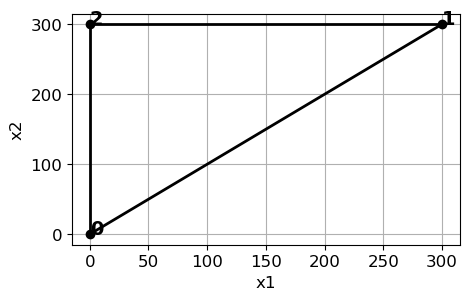

In [29]:
# given:
no_global_nodes  = nodal_positions.shape[0]           # number of global nodes
no_dofs_per_node = 2                                  # number of degrees of freedom per node
no_global_dofs   = no_global_nodes * no_dofs_per_node # total number of dofs 
no_elements      = nodal_connectivities.shape[0]      # number of elements
no_Neumann_BCs   = Neumann_BCs.shape[0]               # number of Neumann boundary conditions
no_Dirichlet_BCs = Dirichlet_BCs.shape[0]             # number of Dirichlet boundary conditions

element_dof_connectivity = []
for item in nodal_connectivities:
    n1, n2 = item
    dofs = [
        n1 * no_dofs_per_node + 0,
        n1 * no_dofs_per_node + 1,
        n2 * no_dofs_per_node + 0,
        n2 * no_dofs_per_node + 1
    ]
    element_dof_connectivity.append(dofs)
element_dof_connectivity = np.array(element_dof_connectivity)


# # Plot initial structure, simply execute this code cell.
plot_initial_structure(nodal_connectivities,nodal_positions,no_global_nodes,no_elements)

In [30]:
grader.check("problem 1 dof connectivity")

problem 1 dof connectivity results: All test cases passed!
problem 1 dof connectivity - 1 message: you have the correct amount of columns in element_dof_connectivity.

#### **solving** 

With all the necessary information set up, we can solve the problem.
We loop over all elements in the structure, construct the element stiffness matrices, rotate these to align with the global coordinate system, and, finally, assemble the element stiffness matrices into the ```global_stiffness_matrix```.
(We may also store some information for post-processing purposes.)
Make sure this step is implemented generically (and not for this specific example), since we will want to reuse the code for other meshes.

In [31]:
# ----------------------------------------------------------------------------------------------------------#
#                                                ASSEMBLE K
# ----------------------------------------------------------------------------------------------------------#2
# intialize the global_stiffness_matrix to the correct size filled with zeros:


global_stiffness_matrix = np.zeros((no_global_dofs,no_global_dofs))


nodal_connectivities

for i in range(no_elements):
    node1 = nodal_connectivities[i,0]
    node2 = nodal_connectivities[i,1]
    num = (nodal_positions[node2][1]) - (nodal_positions[node1][1]) #y values of the node
    denum = (nodal_positions[node2][0]) - (nodal_positions[node1][0]) #x values of the node
    
    angle = np.arctan2(num,denum)

    L = np.sqrt(num**2 + denum**2)

    k = (Ey*A/L)*np.array([[1, -1],[-1, 1]])  #axial stiffness matrix
    R = np.array([[np.cos(angle),np.sin(angle), 0, 0],[0, 0, np.cos(angle), np.sin(angle)]])
    k_elem = R.T@k@R  #element stiffness matrix

    global_stiffness_matrix[np.ix_(element_dof_connectivity[i],element_dof_connectivity[i])]+= k_elem
    
#print(global_stiffness_matrix)


In [32]:
grader.check("problem 1 K")

problem 1 K results: All test cases passed!
problem 1 K - 1 message: problem 1 - the first entry in your global_stiffness_matrix is correct! (problem 1)

Next, the Dirichlet and Neumann boundary conditions must be imposed, and we solve for the global displacement vector, as discussed in class.
Think carefully about the implementation of this step, bearing in mind that we want to compute the reaction forces once we know the displacements. 

Then, let us finally solve a linear system for the global displacement and force vector.

In [33]:
# ----------------------------------------------------------------------------------------------------------#
#                                               APPLYING BCs
# ----------------------------------------------------------------------------------------------------------#
# initialize global force vector filled with zeros:
global_force_vector = np.zeros((no_global_dofs, 1))

# recall that we should work with a copy of of the stiffness matrix when applying BCs
K = global_stiffness_matrix.copy()

#print(Neumann_BCs[0])
for load_index in range(no_Neumann_BCs):
    dof = int(no_dofs_per_node * Neumann_BCs[load_index,0] + Neumann_BCs[load_index,1])
    global_force_vector[dof] = Neumann_BCs[load_index,2]

#print(global_force_vector)

# 
for disp_index in range(no_Dirichlet_BCs):
    dof = int(no_dofs_per_node * Dirichlet_BCs[disp_index,0] + Dirichlet_BCs[disp_index,1])
    K[dof,:] = 0
    K[dof,dof] = 1
    global_force_vector[dof] = Dirichlet_BCs[disp_index,2]


global_displacement_vector =  np.linalg.solve(K,global_force_vector) 
#print(global_displacement_vector)
global_force_vector_ = global_stiffness_matrix@global_displacement_vector
#print(global_force_vector_)


In [34]:
grader.check("problem 1 BCs")

problem 1 BCs results: All test cases passed!
problem 1 BCs - 1 message: nice, for problem 1 you set the force correctly for submission.

#### **post-processing** 

Follow the skeleton script to plot the displaced structure together with the initial configuration. 

For problem 1a) we also output to the screen the global stiffness matrix, the global force vector, the global displacement vector, as well as the stress and strain per element. 
Follow the ```#TODO``` prompts below.


global stiffness matrix in [N/mm]:
[[  49497.47   49497.47  -49497.47  -49497.47      -0.         0.  ]
 [  49497.47  189497.47  -49497.47  -49497.47       0.   -140000.  ]
 [ -49497.47  -49497.47  189497.47   49497.47 -140000.         0.  ]
 [ -49497.47  -49497.47   49497.47   49497.47       0.        -0.  ]
 [     -0.         0.   -140000.         0.    140000.        -0.  ]
 [      0.   -140000.         0.        -0.        -0.    140000.  ]]

strain per element:
[-0.0000101   0.00000714 -0.        ]

stress per element in [MPa]:
['-2.121' '1.500' '-0.000']

displacement vector in [mm]:
[-0.00e+00, 0.00e+00, 2.14e-03, -8.20e-03, 0.00e+00, 0.00e+00]


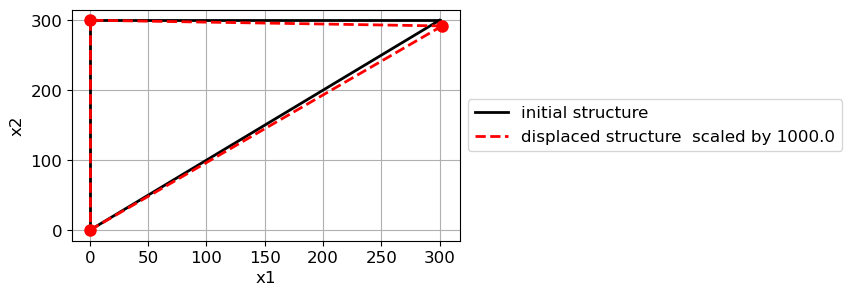

In [35]:
# given:
scale_factor = 1e3
plot_initial_and_displaced_structure(nodal_connectivities, nodal_positions, global_displacement_vector, 
                                     no_elements, scale_factor, problem)
# TODO:                                      
if problem == 1:
    strain_vector = np.zeros(no_elements)
    stress_vector = np.zeros(no_elements)
#     # compute the entries of the strain and stress vector as defined above here:
    for i in range(no_elements):
        nodes = nodal_connectivities[i,:]
        dis_ref = element_dof_connectivity[i]
        x1,y1 = nodal_positions[nodes[0]]
        x2,y2 = nodal_positions[nodes[1]]
        length = np.sqrt((x1-x2)**2+(y1-y2)**2)
        angle = np.arctan2(y2-y1,x2-x1)
        u2_1 = global_displacement_vector[dis_ref[2]]
        u2_2 = global_displacement_vector[dis_ref[3]]
        u1_1 = global_displacement_vector[dis_ref[0]]
        u1_2 = global_displacement_vector[dis_ref[1]]
        u2 = u2_1*np.cos(angle)+u2_2*np.sin(angle)
        u1 = u1_1*np.cos(angle)+u1_2*np.sin(angle)

        strain_vector[i]=((u2-u1)/length).item()
        stress_vector[i]=Ey*strain_vector[i]

    ...
    
    
# finally, we provide you with this print to screen function, simply run this code block to see the results printed to screen
    print_to_screen(global_stiffness_matrix, global_displacement_vector, strain_vector, stress_vector)


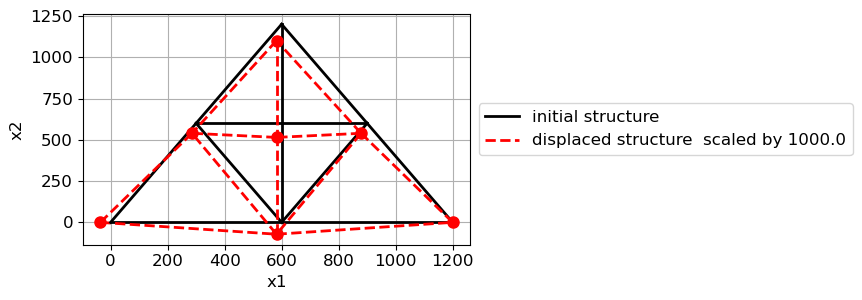

In [26]:
                      
if problem == 2:
    plot_initial_and_displaced_structure(nodal_connectivities, nodal_positions, global_displacement_vector, no_elements, scale_factor, problem)


***

### problem 1 b)

:::{admonition} submission requirement
:class: tip
Your friend decides to use the bracket in the wall to support evermore items hanging from its tip.

Solve the problem for different vertical loads.
Re-run your code **two** times, each time increasing the magnitude of the vertical force by a factor of 100.

*How do you do this?*  Simply go to the pre-processing section of this script and in the input, change the entry in the Neumann boundary condition. When you have done this, simply click on the ⏩ button in the top pane and restart the kernel, or alternetaviely select *Kernel -> Restart & Run All* in the menu.

Record the corresponding displacement at (global) node 1 in the numpy array ```vertial_displacement_at_node_1``` below. 
Further, record the stress and strain in element 1 in the numpy arrays provided.  
(Simply copy the corresponding numerical values displayed above into the provided numpy array below)
:::

In [36]:
vertical_force_applied_at_node_1 = np.array([-300, -30000, -3000000]) #given
# TODO: fill the numerical values into the respective arrays
vertical_displacement_at_node_1 = np.array([-8.20e-03,-8.20e-01,-8.20e+01])  
strain_element1 = np.array([  0.00000714,0.00071429,0.07142857 ])
stress_element1 = np.array([ 1.500,150.000, 15000])

:::{admonition} submission requirement
:class: tip
Now use the provided plotting functions to show a plot of the force vs. displacement at (global) node 1 and a plot of the stress vs. strain in element 1. 

Simply run the following code cell.
:::

<!-- BEGIN QUESTION -->



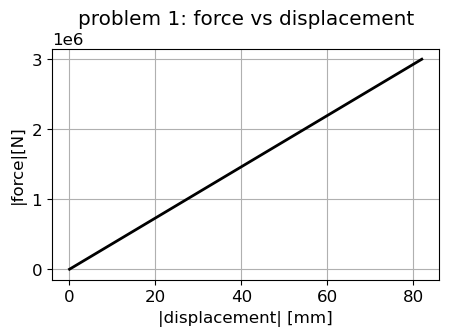

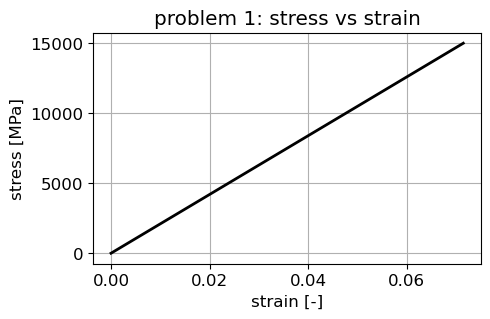

In [37]:
# simply run this code block:
plot_x_vs_y(-vertical_displacement_at_node_1,-vertical_force_applied_at_node_1,
'problem 1: force vs displacement', '|displacement| [mm]', '|force|[N]')
plot_x_vs_y(strain_element1,stress_element1,'problem 1: stress vs strain', 'strain [-]', 'stress [MPa]')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

:::{admonition} submission requirement
:class: tip

The plots of should be displayed above as described in 1b). Do these results make sense physically for large forces/deformations? Explain your answer in the cell below.
:::

The plot obtained does not make sense physically for large forces/deformations. This is because, small angle assumption is being violated for larger forces.

<!-- END QUESTION -->

***

## problem 2 

:::{admonition} submission requirement
:class: tip

Now that you have set up and verified your FE code, we want to try out a different input.
Construct a statically determinate framework consisting of at least **10 bars**. 
Use essential boundary conditions to avoid rigid body motion and load the structure by imposing some **non-zero *displacements***. 
Be creative!

All that is required here is that you go to the pre-processing section at the beginning of the code to code cell 3 and add the input for problem 2 then proceed to code cell 4 and enter problem = 2. Then run all cells and have a look at the outcome! It should work perfectly fine.

:::

<!-- BEGIN QUESTION -->

***
## problem 3


:::{admonition} submission requirement
:class: tip

Finally, enter problem = 3 in code cell 4. Then run the script (i.e. execute all cells by clicking on the ⏩ button in the top pane and restarting the kernel, or alternetaviely by selecting *Kernel -> Restart & Run All* in the menu). It will run with the provided input file called mystery_structure so that you can get to admire a *real-life* structure. 

Take a look at the initial and deformed structure in the post-processing step, can you identify what the structure represents? ;-) 

Your code should be able to handle the provided input function without any problems. Run your code once with this input. It should show the figure in small right below this text. If it does not show up, make sure that the code block below is uncommented and execute this block again once you successfully ran problem = 3.
:::

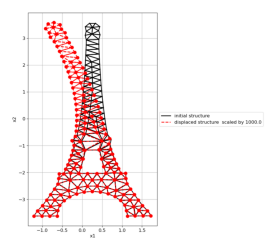

In [16]:
show_plot_problem3()

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

***

## Closing remarks

When you reach this part of the script, your code should be running just fine. 
In the inputs section we can select the input corresponding to problems 1,2 and 3, respectively, and the code should execute without any problems. 
Further, you have taken some time to interpret some of the results. 

To close off this assignment on truss structures, write down three points of what you have learned during this project in the provided space below.

As a final point, you can also give an indication of how long it took you to complete this assignment. 

_Type your answer here, replacing this text._

In [ ]:
grader.check("Check saved problem 1 for submission")

<!-- END QUESTION -->

:::{admonition} important
:class: attention

**Run** and **save** your code with **problem = 1** in code cell 4 before submitting through Moodle! Make sure that your notebook is called **lab2.ipynb** and that you submit your entire coding-lab-2 folder containing the notebook and all its dependencies.

Best of luck!

:::